In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralnet import NeuralNetwork
from neuralnet.layers import Convolutional, Dense, Reshape, activations
from neuralnet.losses import binnary_cross_entropy, binnary_cross_entropy_prime

print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

numpy version: 1.26.4
pandas version: 2.2.2


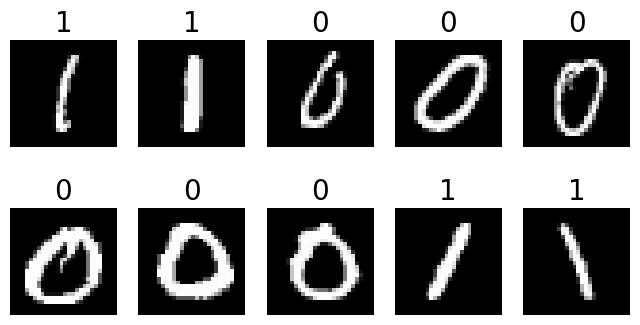

In [8]:
# load dataset
df = pd.read_csv("./dataset/mnist_train.csv")
df_one_zero = df[(df["label"] == 1) | (df["label"] == 0)]

# train test split
def train_test_split(df, target_col, train_size=0.7):
    train = df.sample(frac=train_size)
    test = df.drop(train.index)

    X_train = train.drop(columns=target_col)
    y_train = train["label"]
    X_test = test.drop(columns=target_col)
    y_test = test["label"]

    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = train_test_split(df_one_zero, "label", train_size=0.5)

# preprocess data
def one_hot_encoder(num_list):
    n_classes = np.max(num_list) + 1
    return np.eye(n_classes)[num_list]

def preprocess_data(x, y, label, limit):
    df_concat = pd.concat([x, y], axis=1)
    df_zero = df_concat[df_concat[label] == 0].head(limit)
    df_one = df_concat[df_concat[label] == 1].head(limit)
    df_concat = pd.concat([df_zero, df_one]).sample(frac=1)
    x = df_concat.drop(columns=label).values
    y = df_concat[label]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = one_hot_encoder(y)
    y = y.reshape(len(y), 2, 1)
    return x, y

X_train, y_train = preprocess_data(X_train, y_train, "label", 500)
X_test, y_test = preprocess_data(X_test, y_test, "label", 500)

# plot some images
fig, ax = plt.subplots(2,5, figsize=(8,4))
ax = ax.flatten()
idx = np.random.randint(0, 100, size=10)
for i in range(10):
    ax[i].imshow(X_train[idx[i], :].reshape(28, 28), cmap='gray')
    ax[i].axis('off') # hide the axes ticks
    ax[i].set_title(str(int(np.argmax(y_train[idx[i]]))), color= 'black', fontsize=20)
plt.show()

In [9]:
# neural network
network = NeuralNetwork(layers=[
    Convolutional(input_shape=(1, 28, 28), kernel_size=3, output_depth=5),
    activations.Sigmoid(),
    Reshape(input_shape=(5, 26, 26), output_shape=(5 * 26 * 26, 1)),
    Dense(input_size=(5 * 26 * 26), output_size=100),
    activations.Sigmoid(),
    Dense(input_size=100, output_size=2),
    activations.Sigmoid()
])

# train the model
network.fit(
    X_train,
    y_train,
    loss=binnary_cross_entropy,
    loss_prime=binnary_cross_entropy_prime, 
    epochs=100,
    learning_rate=0.1,
    verbose=True)

Epoch 1/100, error=0.15736045947066182
Epoch 2/100, error=0.032429987144385594
Epoch 3/100, error=0.021087024413530133
Epoch 4/100, error=0.018358564254923906
Epoch 5/100, error=0.009721325592685825
Epoch 6/100, error=0.005329187385715679
Epoch 7/100, error=0.009912661889465692
Epoch 8/100, error=0.008246467243406311
Epoch 9/100, error=0.0029424069372294363
Epoch 10/100, error=0.0017568370396529949
Epoch 11/100, error=0.0015075835502204248
Epoch 12/100, error=0.0013695195633775933
Epoch 13/100, error=0.0012437731122574148
Epoch 14/100, error=0.001127047095211961
Epoch 15/100, error=0.0010154299194013808
Epoch 16/100, error=0.0009213876279975877
Epoch 17/100, error=0.0008477277632006014
Epoch 18/100, error=0.000788197968817945
Epoch 19/100, error=0.0007387392989998823
Epoch 20/100, error=0.0006969648387930094
Epoch 21/100, error=0.0006610499909662015
Epoch 22/100, error=0.0006295762659325545
Epoch 23/100, error=0.0006015317960767991
Epoch 24/100, error=0.0005762016621404444
Epoch 25/100

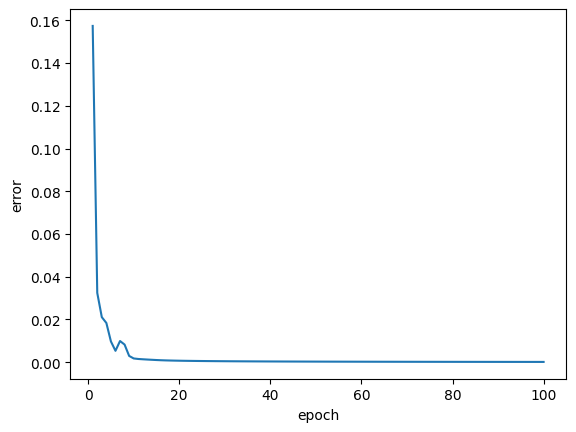

In [10]:
# plot error
error_df = network.error_df

fig, ax = plt.subplots()
ax.plot(error_df['epoch'], error_df['error'])
ax.set(xlabel='epoch', ylabel='error')

plt.show()

In [11]:
correct_count = 0
for x, y in zip(X_test, y_test):
    output = network.predict(x)
    if np.argmax(output) == np.argmax(y):
        correct_count += 1
        
print(f"Accuracy: {correct_count / len(X_test)}")

# for x, y in zip(X_test, y_test):
#     output = network.predict(x)
#     print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")

Accuracy: 0.998
